In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

import glob
import time
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV




In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# class save_images ( object ):
#     def __init__( self ):
#         self.i = 0
#     def __call__( self, image):
#         # do somethingc
#         self.i +=1
#         cv2.imwrite("test_images_project/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
#         return image
    
# save_images = save_images()    
    
# ## creating additional test images
# from moviepy.editor import VideoFileClip
# output_video_name = 'test_video_output.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# clip2 = clip1.subclip(0,15)
# output_video = clip2.fl_image(lambda x:save_images(x)) #NOTE: this function expects color images!!
# %time output_video.write_videofile(output_video_name, audio=False)
# import os
# os.remove('test_video_output.mp4')
# print ("Completed")


### Create a mask

In [2]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    vertices = np.array([[(0,       img.shape[0] ),                    # <-- bottom left
                          (0,       img.shape[0]*.9 ),                    # <-- bottom left
                          (.55*img.shape[1] ,  .5*img.shape[0]),                    # <-- top left
                          (.8*img.shape[1],   .5*img.shape[0]),                    # <-- top right
                          (img.shape[1],      img.shape[0]*.5),
                          (img.shape[1],      img.shape[0]) 
                         ]], dtype=np.int32)  # <-- bottom right
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    masked_image[masked_image ==0 ] = 0
    return masked_image

### CHECK IF A POINT ( USED FOR THE CAR BOXES ) IS INSIDE THE AREA OF INTERESTS

In [3]:
def inside_polygon(x_pos, y_pos, img, points):
#     """
#     Return True if a coordinate (x, y) is inside a polygon defined by
#     a list of verticies [(x1, y1), (x2, x2), ... , (xN, yN)].

#     Reference: http://www.ariel.com.au/a/python-point-int-poly.html
#     """
   ## inverting because the coords to the cartesian coordinates
#     y = img.shape[0] -  y_pos
#     x = img.shape[1] -  x_pos
    y =  y_pos
    x =  x_pos    
#     print ( " x = {}, y = {}".format(x,y))
    n = len(points)
    inside = False
    p1x, p1y = points[0]
    for i in range(1, n + 1):
        p2x, p2y = points[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

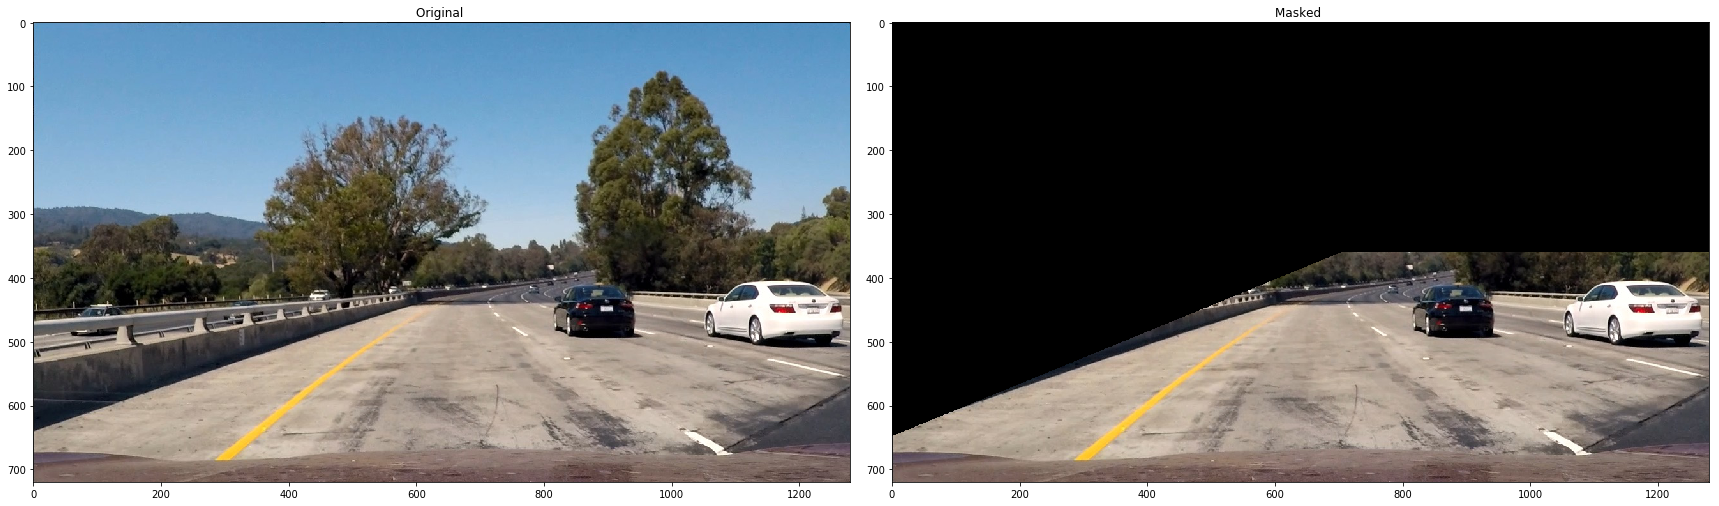

 point with coordinates (y_pos = 400,x_pos = 1000 ) is INSIDE AREA OF INTEREST
 point with coordinates (y_pos = 0,x_pos = 100 ) is OUTSIDE area of interest


In [4]:
img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title("Original ")
# ax1.axis('off')

ax2.imshow(region_of_interest(img))
ax2.set_title("Masked " )
# ax2.axis('off')

plt.show()

vertices = np.array([(0,       img.shape[0] ),                    # <-- bottom left
                      (0,       img.shape[0]*.9 ),                    # <-- bottom left
                      (.55*img.shape[1] ,  .5*img.shape[0]),                    # <-- top left
                      (.8*img.shape[1],   .5*img.shape[0]),                    # <-- top right
                      (img.shape[1],      img.shape[0]*.5),
                      (img.shape[1],      img.shape[0]) 
                     ], dtype=np.int32)  # <-- bottom right


# print(vertices)
x_pos = 1000 
y_pos = 400
if inside_polygon (img=img, x_pos = x_pos , y_pos= y_pos , points=vertices) == True :
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is INSIDE AREA OF INTEREST".format(y_pos, x_pos))
else:
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is OUTSIDE area of interest".format(y_pos, x_pos))


x_pos = 100 
y_pos = 0
if inside_polygon (img=img, x_pos = x_pos , y_pos= y_pos , points=vertices) == True :
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is INSIDE AREA OF INTEREST".format(y_pos, x_pos))
else:
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is OUTSIDE area of interest".format(y_pos, x_pos))
   

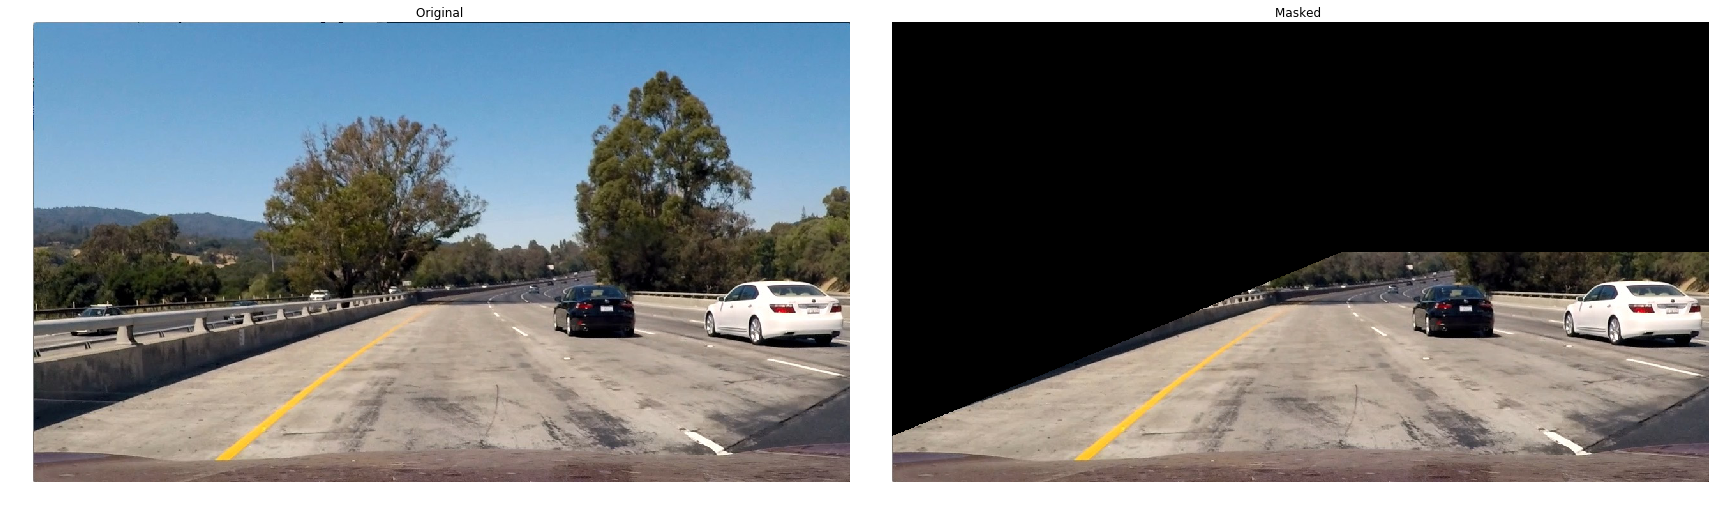

 point with coordinates (y_pos = 720,x_pos = 100 ) is INSIDE AREA OF INTEREST
 point with coordinates (y_pos = 0,x_pos = 100 ) is OUTSIDE area of interest


In [5]:
img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title("Original ")
ax1.axis('off')

ax2.imshow(region_of_interest(img))
ax2.set_title("Masked " )
ax2.axis('off')

plt.show()

vertices = np.array([(0,       img.shape[0] ),                    # <-- bottom left
                      (0,       img.shape[0]*.9 ),                    # <-- bottom left
                      (.55*img.shape[1] ,  .5*img.shape[0]),                    # <-- top left
                      (.8*img.shape[1],   .5*img.shape[0]),                    # <-- top right
                      (img.shape[1],      img.shape[0]*.5),
                      (img.shape[1],      img.shape[0]) 
                     ], dtype=np.int32)  # <-- bottom right

# print(vertices)
x_pos = 100 
y_pos = 720
if inside_polygon (img=img, x_pos = x_pos , y_pos= y_pos , points=vertices) == True :
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is INSIDE AREA OF INTEREST".format(y_pos, x_pos))
else:
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is OUTSIDE area of interest".format(y_pos, x_pos))


x_pos = 100 
y_pos = 0
if inside_polygon (img=img, x_pos = x_pos , y_pos= y_pos , points=vertices) == True :
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is INSIDE AREA OF INTEREST".format(y_pos, x_pos))
else:
   print ( " point with coordinates (y_pos = {},x_pos = {} ) is OUTSIDE area of interest".format(y_pos, x_pos))
   

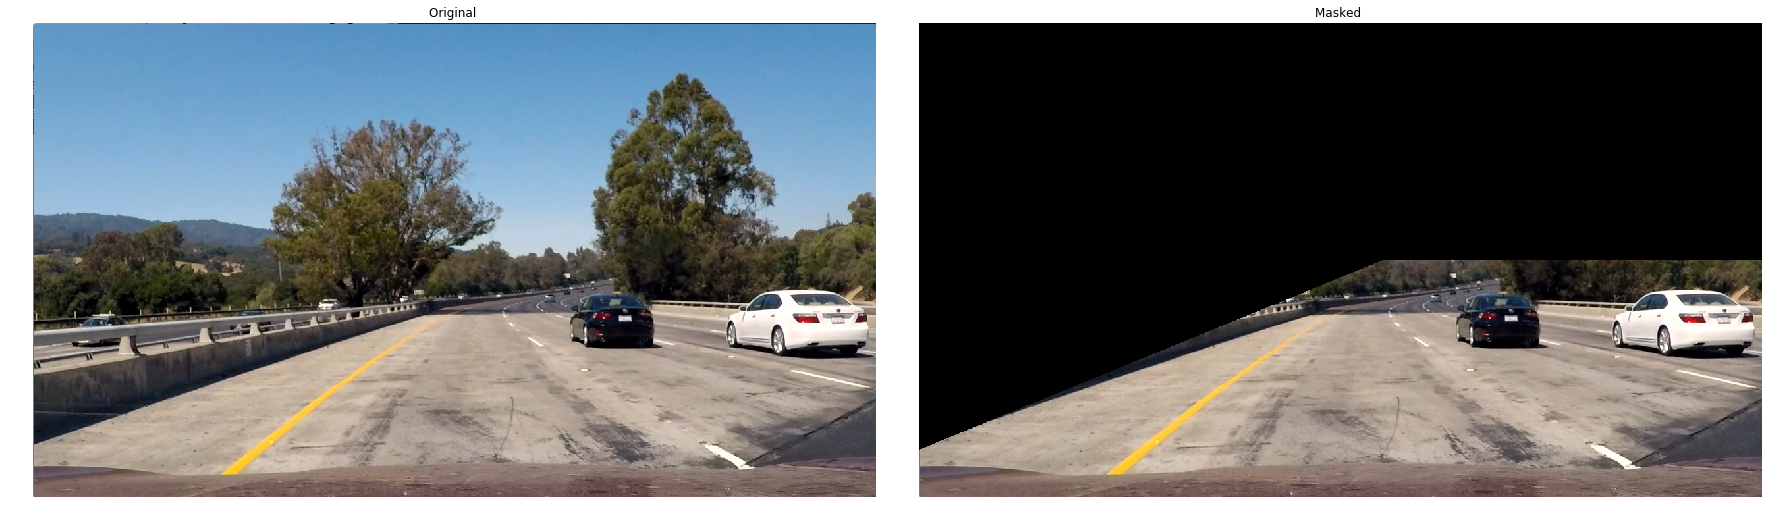

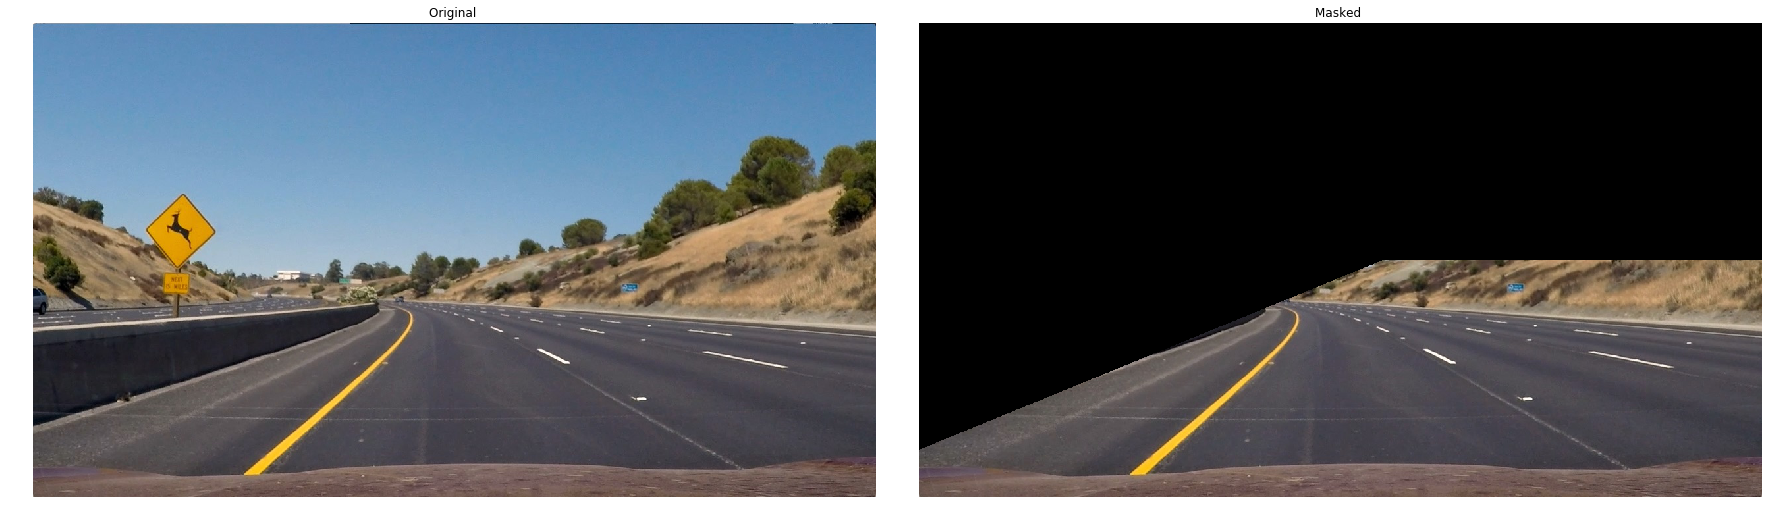

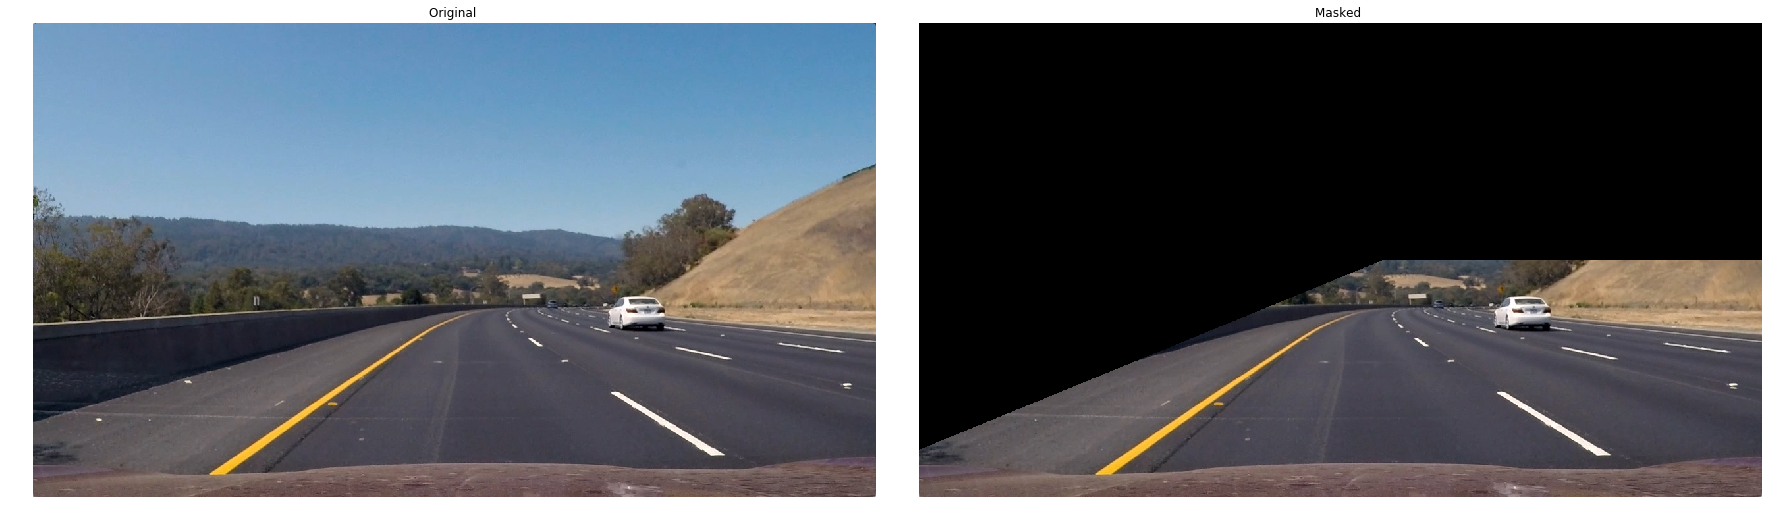

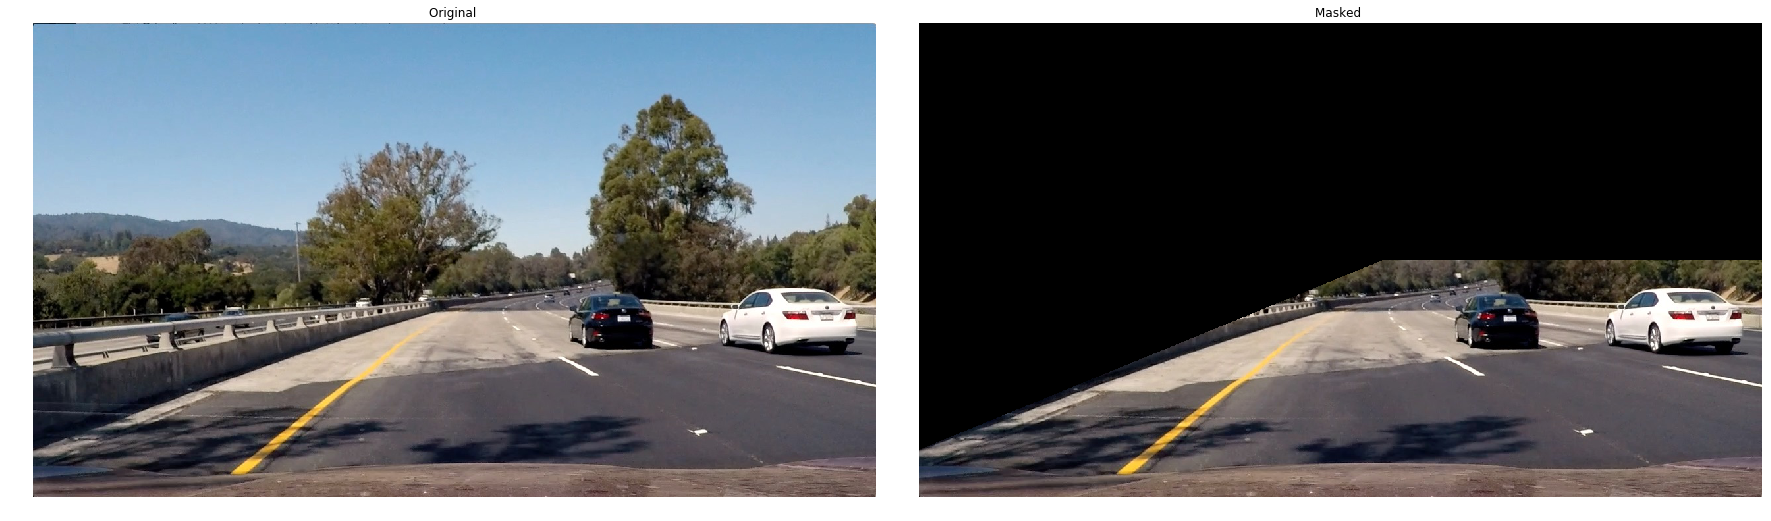

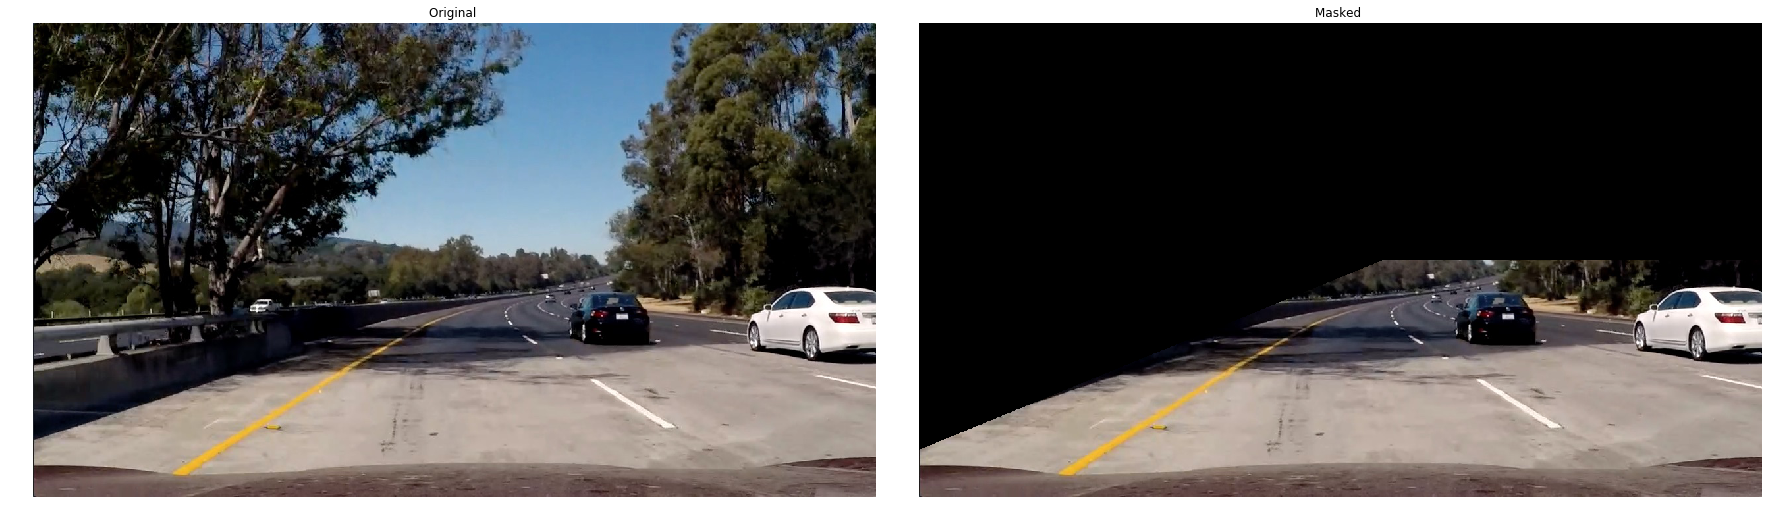

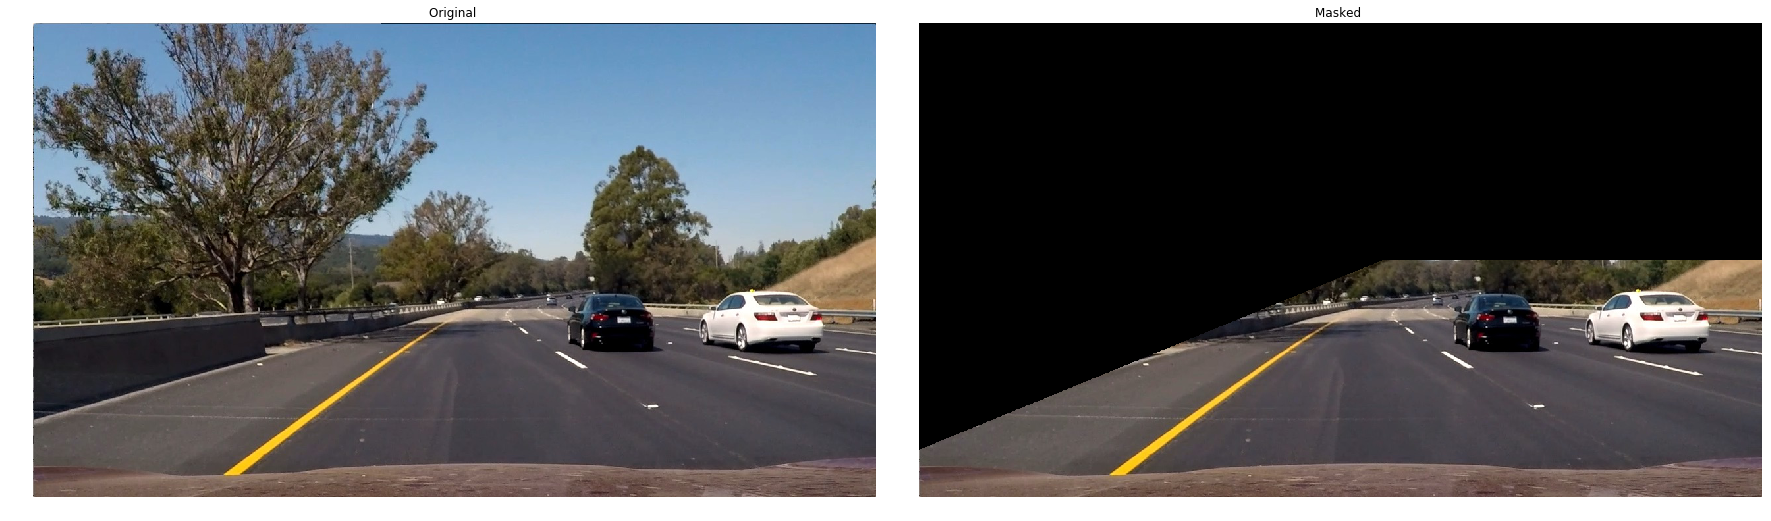

In [6]:
for image_name  in  sorted(glob.glob('test_images/*')):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title("Original ")
    ax1.axis('off')

    ax2.imshow(region_of_interest(image))
    ax2.set_title("Masked " )
    ax2.axis('off')

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


### region of interests on the entire video

In [7]:
# from moviepy.editor import VideoFileClip
# output_video_name = 'project_video_output_masked.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# output_video = clip1.fl_image(lambda x: region_of_interest(x)) #NOTE: this function expects color images!!
# %time output_video.write_videofile(output_video_name, audio=False,verbose=False)
# print ("Completed")

## image_features_extractor

In [8]:
class image_features_extractor:
    def __init__(self    \
        ,color_space           # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        ,orient                # HOG orientations 
        ,pix_per_cell          # HOG pixels per cell 
        ,cell_per_block        # HOG cells per block 
        ,spatial_size          # Spatial binning dimensions
        ,spatial_feat          # Spatial features on or off
        ,hist_feat             # Histogram features on or off
        ,hog_feat              # HOG features on or off
        ,nbins                 # Number of color histogram bins
        ,bins_range
        ,image_size
        ,debug=False
                ):

        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.nbins=nbins
        self.bins_range=bins_range
        self.debug =debug
        self.image_size = image_size

    # Define a function to compute binned color features  
    def bin_spatial(self,feature_image):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, self.spatial_size).ravel() 
        # Return the feature vector
        return features

    # Define a function to compute color histogram features  
    def color_hist(self,feature_image):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(feature_image[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(feature_image[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(feature_image[:,:,2], bins=self.nbins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        self.hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#         hist_features = channel1_hist[0]

        if self.debug:
            # Generating bin centers
            bin_edges = channel1_hist[1]
            bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
            # Plot a figure with all three bar charts
            fig = plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.bar(bin_centers, channel1_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 0 Histogram')
            plt.subplot(132)
            plt.bar(bin_centers, channel2_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 1 Histogram')
            plt.subplot(133)
            plt.bar(bin_centers, channel3_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 2 Histogram')
            plt.show()

       
        # Return the individual histograms, bin_centers and feature vector
        return self.hist_features

    def get_hog_features(self, feature_image):
        if self.debug:
            # feature_image is 1 channel image
            hog_features ,hog_image    = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=True)
            return hog_features, hog_image

        
        else:
            # feature_image is 1 channel image
            hog_features     = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=True)
            return hog_features



    def get_all_features (self, img):
        if self.debug:
            print( "get_all_features image shape "+ str(img.shape))
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
#                 print (" Color space YCrCb ")
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
            
        
        if feature_image.shape[0] == self.image_size[0] and\
           feature_image.shape[1] == self.image_size[1]:
            pass #print (" feature_image.shape == self.image_size")
        else:
             print (" feature_image.shape = " + str(feature_image.shape))
             print (" self.image_size = "     + str(self.image_size))
             feature_image = cv2.resize(feature_image, self.image_size)    
                
        if self.debug:
            f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
            f.tight_layout()
            

            ax1.imshow(feature_image[:,:,0],cmap="gray")
            ax1.set_title("Image in format " + self.color_space + " channel 0 ")
            ax1.axis('off')
            
            ax2.imshow(feature_image[:,:,1],cmap="gray")
            ax2.set_title("Image in format " + self.color_space+ " channel 1 ")
            ax2.axis('off')

            ax3.imshow(feature_image[:,:,2],cmap="gray")
            ax3.set_title("Image in format " + self.color_space+ " channel 2 ")
            ax3.axis('off')

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()


            
        img_features = []

        if self.spatial_feat == True:
            img_features.append(self.bin_spatial(feature_image))

        if self.hist_feat == True:
            img_features.append(self.color_hist(feature_image))
            
        if self.hog_feat == True:
#             gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#             hog_features = self.get_hog_features(gray_image)
            hog_features = []
            if self.debug:
                f, axarr = plt.subplots(1, 3, figsize=(24, 9))
                f.tight_layout()
            
            for channel in range(feature_image.shape[2]):
                if self.debug:
                    temp, hog_image = self.get_hog_features(feature_image[:,:,channel])
                    
                    axarr[channel].imshow(hog_image,cmap="gray")
                    axarr[channel].set_title("Image in format " + self.color_space + " channel 0 ")
                    axarr[channel].axis('off')

                else:
                    temp = self.get_hog_features(feature_image[:,:,channel])
                    
                hog_features.extend(temp)      
                
            img_features.append(hog_features)
            
            if self.debug:
                plt.show()


            
        #9) Return concatenated array of features
    #     print (img_features)
        return np.concatenate(img_features)                
    

### Car Detector from images ( train & prediction )

In [9]:
class image_car_detector:
    def __init__(self, extractor, 
                 cars_folder='train_data/car', 
                 notcars_folder='train_data/non-car',
                 limit_images=None):
        self.cars_folder    = cars_folder
        self.notcars_folder = notcars_folder

        self.car_images_list     = []
        self.notcars_images_list = []
        self.extractor = extractor
        
        self.car_features = []
        self.notcar_features = []
        self.limit_images = limit_images

        
    def load_images_list(self):
        self.car_images_list     = []
        self.notcars_images_list = []
    
        # loading cars
        for subfolder in glob.glob(self.cars_folder + '/*'):
          print ("subfolder = " + subfolder)
          for image  in  glob.glob(subfolder+'/*'):
               self.car_images_list.append(image)

        # loading non cars
        for subfolder in glob.glob(self.notcars_folder+ '/*'):
          for image  in  glob.glob(subfolder+'/*'):
               self.notcars_images_list.append(image)
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_imgs_features(self):
        # Iterate through the list of images
        if self.limit_images:
            x_limit = self.limit_images
            print (" limiting the number of images to " + str(x_limit))
        else:
            x_limit = len(self.car_images_list)
            print (" processing " + str(x_limit) +" images "  )

#         x_limit = 100
        print ( " ")
        print (" Extracting features from cars ....")
        # CARS FEATURES 
        self.car_features = []


        for file in self.car_images_list[:x_limit]:
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_features = self.extractor.get_all_features(image)
#             print ( " features length = " + str(len(temp_features)))
            self.car_features.append(temp_features)
            
        print (" .. completed ( features per image = " + str(len(self.car_features[0])) + ")")

            
        print ( " ")
        print (" Extracting features from non cars ....")
        # NOT CAR FEATURES 
        self.notcar_features = []
        # Iterate through the list of images
        for file in self.notcars_images_list[:x_limit]:
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_features = self.extractor.get_all_features(image)
#             print ( " features length = " + str(len(temp_features)))
            self.notcar_features.append(temp_features)
        print (" .. completed ( features per image = " + str(len(self.notcar_features[0])) + ")")

        print (" ")

        
  


    def search_windows(self, img, windows, cars_classifier):
        self.on_windows = []
        for window in windows:
            #3) Extract the test window from original image
            ###[startx, starty, endx, endy]
            check = inside_polygon (img=img, 
                                           x_pos = window[0] ,    # --> x1 position 
                                           y_pos=  window[1] ,    # --> y1 position 
                                           points=vertices) == True

            if check == True:
                    test_img = img[window[1]:window[3], window[0]:window[2]]
                    test_img = cv2.resize(test_img, (64,64))

                    if cars_classifier.type == "CNN":
                        prediction = cars_classifier.predict(test_img)

                    else:
                        #4) Extract features for that window using single_img_features()
                        features = self.extractor.get_all_features(test_img)
                        features_reshaped = np.array(features).reshape(1, -1)
                        #5) Scale extracted features to be fed to classifier
                        test_features = cars_classifier.X_scaler.transform(np.array(features).reshape(1, -1))
                        #6) Predict using your classifier
                        prediction = cars_classifier.predict(test_features)

                    #7) If positive (prediction == 1) then save the window
                    if prediction == "car":
                        self.on_windows.append(window)
            else:
                    print ( "search_windows : window is outside area of interests")
                
        return self.on_windows

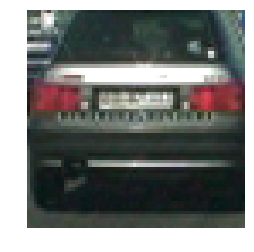

get_all_features image shape (64, 64, 3)


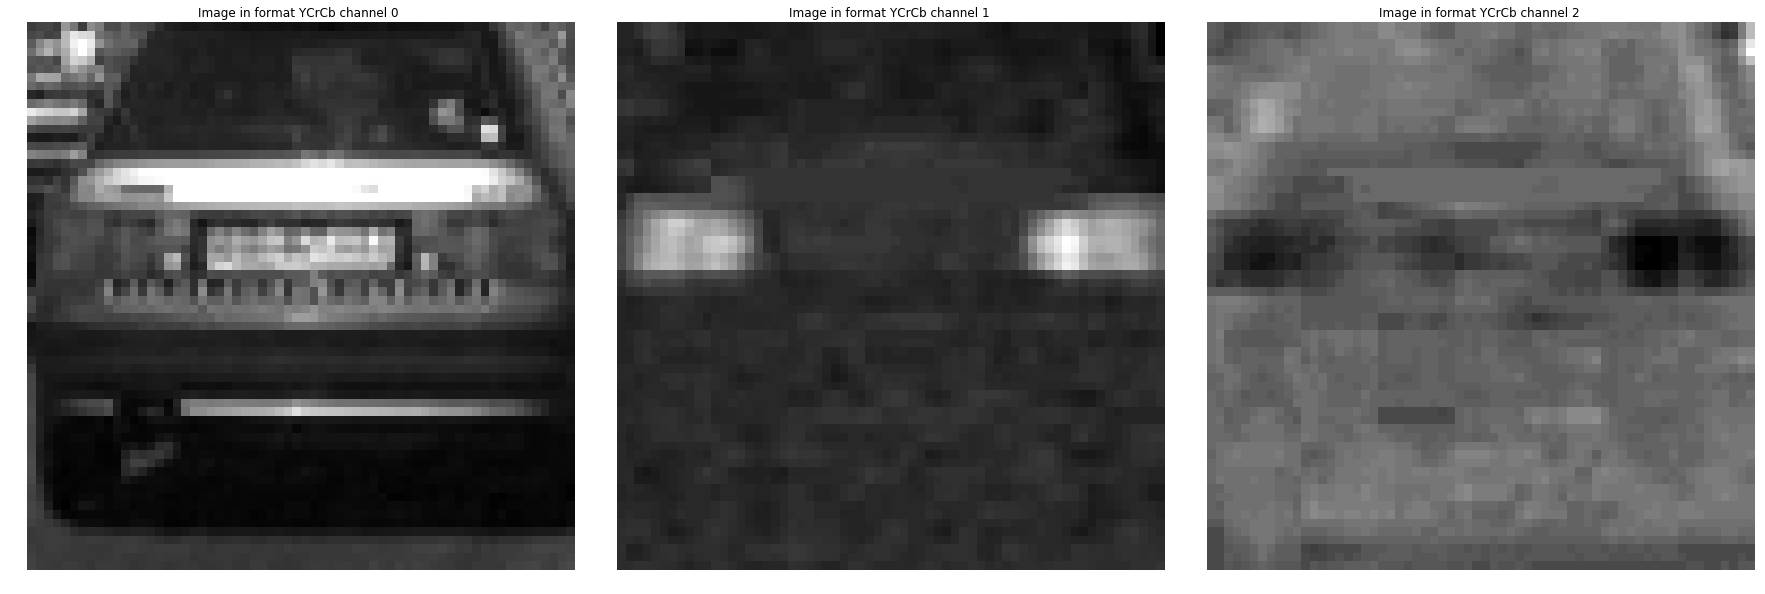

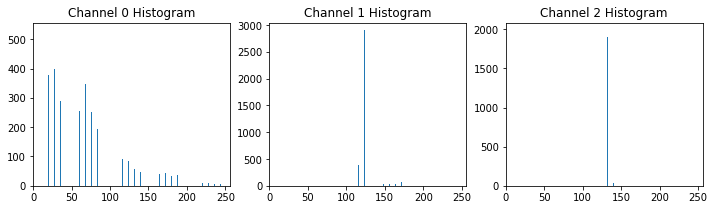

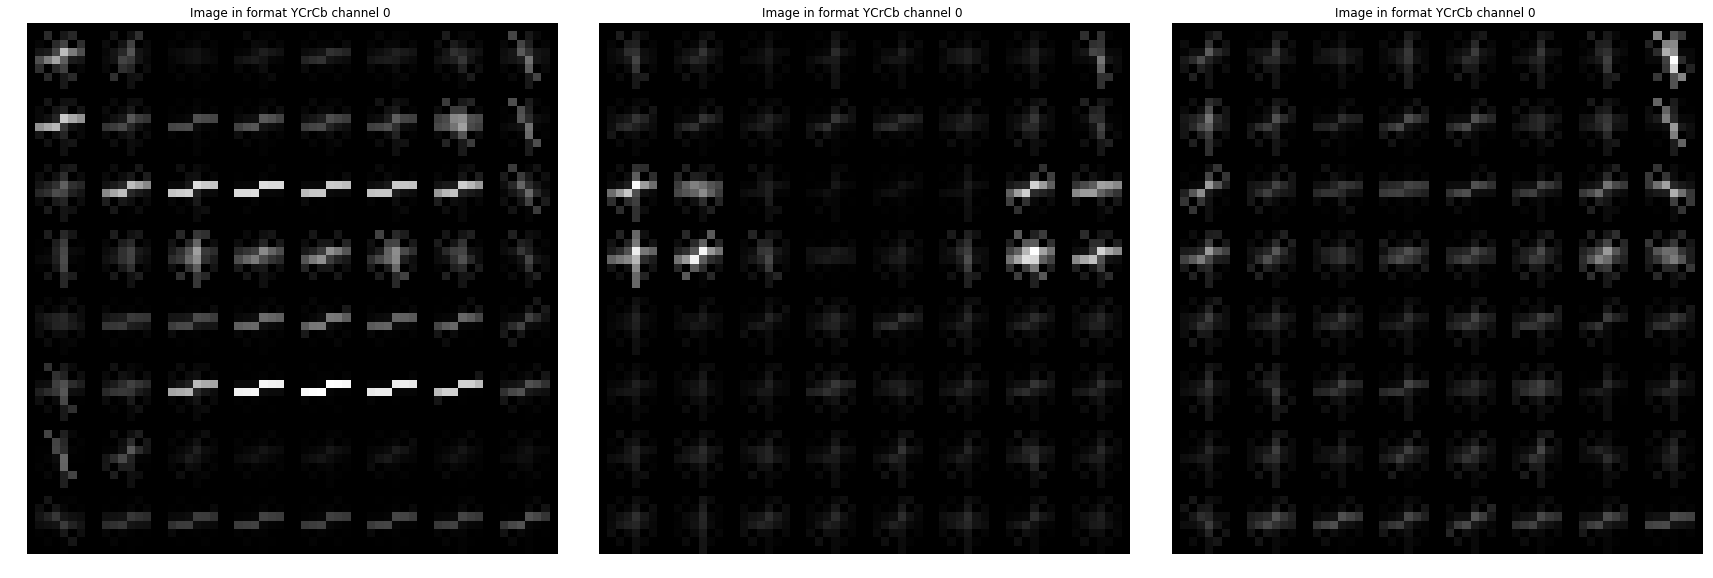

(8460,)

In [10]:
import cv2
image = cv2.imread('train_data/car/GTI_MiddleClose/image0110.png')
image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# color space = RGB, HSV, LUV, HLS, YUV, YCrCb
extractor = image_features_extractor(color_space= 'YCrCb' #'YCrCb'
                                    ,pix_per_cell=8
                                    ,cell_per_block=2
                                     
                                    ,orient=9
                                    ,spatial_feat = True     # Spatial features on or off
                                    ,hist_feat = True        # Histogram features on or off
                                    ,hog_feat = True  
                                    ,spatial_size = (32, 32)
                                    ,bins_range=(0, 256)
                                    ,nbins=32
                                    , debug=True
                                    , image_size = (64,64)  
                                    )
plt.imshow(image)
plt.axis("off")
plt.show()

all_features = extractor.get_all_features(image)
all_features.shape


### Defining the classifier HOG + Neural Network

In [11]:
class classifier_hog_nn:
    def __init__(self, car_features, notcar_features):
        self.car_features = car_features
        self.notcar_features = notcar_features
        self.type="HOG+NEURAL"
                 
    def train(self, parameters=[1, 10], epochs=20,batch_size = 32,verbose =False):
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        print (scaled_X)
        
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

        #################
        # #### START TRAINING 
        #################

        import time

        print ( "Start training ... ")
        t=time.time()
        from keras.models import Sequential
        from keras.layers import Dense, Dropout
        from keras.utils import to_categorical
        
        self.clf = Sequential()
        
        self.clf.add(Dense(64, input_shape=(len(self.car_features[0]),), name="dense1"))
        self.clf.add(Dense(128, activation='relu', name="dense2"))
        self.clf.add(Dropout(0.2))
        self.clf.add(Dense(1, activation='sigmoid', name="final"))
        
        self.clf.compile('adam', 'binary_crossentropy', ['accuracy'])

            
        history = self.clf.fit(self.X_train, self.y_train,
                    batch_size=batch_size,
                    epochs = epochs,
                    verbose=verbose,
                    shuffle=True,
                    validation_split=0.1,           
                    )
                  
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train the classifier...')

        # Check the score of the SVC
        score = self.clf.evaluate(self.X_test, self.y_test)

#         print('Test Accuracy of SVC = ', round(self.clf.score(X_test, y_test), 4))
        print( " ")
        print('Test Accuracy of classifier = ' + str(score[1]))

    def predict(self, features):
        prediction = self.clf.predict(features).squeeze()
        if prediction >  0.9:
#         if prediction ==   1:
            return "car"
        else:
            return "non-car"
        
        
    
    def save_classifier(self):
        self.clf.save("keras_model.h5")
        
        import pickle
#         # save the classifier
#         with open('car_detection_classifier.pkl', 'wb') as fid:
#             pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
#         with open('car_detection_classifier.pkl', 'rb') as fid:
#             self.clf = pickle.load(fid)
        from keras.models import load_model
        self.clf = load_model("keras_model.h5")
        
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")  

### Features extraction and Classifier training

In [12]:
extractor.debug = False

detector = image_car_detector(extractor) #, limit_images= 2000)

detector.load_images_list()

detector.extract_imgs_features()


subfolder = train_data/car/GTI_Far
subfolder = train_data/car/GTI_MiddleClose
subfolder = train_data/car/GTI_Right
subfolder = train_data/car/KITTI_extracted
subfolder = train_data/car/GTI_Left
subfolder = train_data/car/other
 processing 8804 images 
 
 Extracting features from cars ....
 .. completed ( features per image = 8460)
 
 Extracting features from non cars ....
 .. completed ( features per image = 8460)
 


In [14]:
cars_classifier_hog_nn = classifier_hog_nn(detector.car_features, detector.notcar_features)
cars_classifier_hog_nn.train(epochs=30,batch_size=128, verbose=True)

cars_classifier_hog_nn.save_classifier()
cars_classifier_hog_nn.load_classifier()

.....Scaling...
[[-0.82333621 -0.36694276  0.2489828  ...,  0.71367591 -0.6215077
  -0.46152522]
 [-0.30375875 -0.5962478   0.2489828  ..., -0.50136792 -0.6215077
  -0.46152522]
 [-0.51875632  0.09166732  0.42811166 ...,  1.51768299  0.69966835
  -0.46152522]
 ..., 
 [-0.930835    0.20631984 -0.01971048 ..., -0.23297182  0.10221229
  -0.46152522]
 [-0.1783435  -0.94020536  0.06985395 ...,  0.27512638 -0.6215077
  -0.46152522]
 [-0.53667279 -0.5962478   0.33854723 ...,  1.84040285 -0.6215077
  -0.46152522]]
Start training ... 
Train on 14262 samples, validate on 1585 samples
Epoch 1/30
14262/14262 [==============================] - 1s 50us/step - loss: 0.0891 - acc: 0.9708 - val_loss: 0.0393 - val_acc: 0.9868
Epoch 2/30
14262/14262 [==============================] - 1s 41us/step - loss: 0.0217 - acc: 0.9938 - val_loss: 0.0279 - val_acc: 0.9931
Epoch 3/30
14262/14262 [==============================] - 1s 41us/step - loss: 0.0174 - acc: 0.9954 - val_loss: 0.0228 - val_acc: 0.9931
Epoch 4/

### TESTING HOG + NEURAL NETWORK CLASSIFIER

In [15]:
import cv2

print ( "*************************************************************")        
print ( "** TESTING NEURAL NETWORK CLASSIFIER .....") 
print ( "*************************************************************")        


def classify(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    temp_features = extractor.get_all_features(image)
    # Scale extracted features to be fed to classifier
    temp_features = cars_classifier_hog_nn.X_scaler.transform(np.array(temp_features).reshape(1, -1))
    # Predict using your classifier
    prediction = cars_classifier_hog_nn.predict(temp_features)
    return prediction

corrected_predictions = 0
wrong_predictions = 0

######
#### cars 
######
print ( " Predicting CARS")
for folder  in  sorted(glob.glob('train_data/car/*')):
    print ( " Predicting CARS folder " + str(folder))
    for file in glob.glob(folder+ "/*"):
        prediction = classify(file)
        if prediction == "car":
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

######
#### NON cars 
######
print ( " ")
print ( " Predicting NON CARS")
for folder  in  sorted(glob.glob('train_data/non-car/*')):
    print ( " Predicting NON CARS folder " + str(folder))
    for file in glob.glob(folder + "/*"):
        prediction = classify(file)
        if prediction == "non-car":
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

print ( "*************************************************************")        
print ( "** NEURAL NETWORK CLASSIFIER ..... ")
print ( "**   Corrected predictions {}".format(corrected_predictions))        
print ( "**   Wrong     predictions {}".format(wrong_predictions))        
print ( "*************************************************************")        


*************************************************************
** TESTING NEURAL NETWORK CLASSIFIER .....
*************************************************************
 Predicting CARS
 Predicting CARS folder train_data/car/GTI_Far
                                     ..... correct= 829 , wrong=5 
 Predicting CARS folder train_data/car/GTI_Left
                                     ..... correct= 1733 , wrong=10 
 Predicting CARS folder train_data/car/GTI_MiddleClose
                                     ..... correct= 2151 , wrong=11 
 Predicting CARS folder train_data/car/GTI_Right
                                     ..... correct= 2810 , wrong=16 
 Predicting CARS folder train_data/car/KITTI_extracted
                                     ..... correct= 8773 , wrong=19 
 Predicting CARS folder train_data/car/other
                                     ..... correct= 8785 , wrong=19 
 
 Predicting NON CARS
 Predicting NON CARS folder train_data/non-car/Extras
                            

### Re-Defining the classifier as Svm


In [16]:
class classifier_svm():
    def __init__(self, car_features, notcar_features):
        self.car_features = car_features
        self.notcar_features = notcar_features
        self.type="SVM"
                 
    def train(self, parameters=[1, 10], epochs=20,batch_size = 32,verbose =False):
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

        #################
        # #### START TRAINING 
        #################

        import time

        print ( "Start training ... ")
        t=time.time()
        self.clf = svm.LinearSVC()

        self.clf.fit(self.X_train, self.y_train)
        
        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train the classifier...')

        # Check the score of the SVC
        score = self.clf.score(self.X_test, self.y_test)

        print( " ")
        print('Test Accuracy of classifier = ' + str(score))

    def predict(self, features):
        prediction = self.clf.predict(features).squeeze()
        if prediction >  0.9:
#         if prediction ==  1:
            return "car"
        else:
            return "non-car"

    def save_classifier(self):
        
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'wb') as fid:
            pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'rb') as fid:
            self.clf = pickle.load(fid)
        
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")  

#### training the SVM classifier


In [17]:
cars_classifier_svm = classifier_svm(detector.car_features, detector.notcar_features)
cars_classifier_svm.train()

cars_classifier_svm.save_classifier()
cars_classifier_svm.load_classifier()


.....Scaling...
Start training ... 
18.15 Seconds to train the classifier...
 
Test Accuracy of classifier = 0.992617830778
 .. classifier saved 
 .. classifier loaded 


### TESTING SVM CLASSIFIER

In [18]:
import cv2

print ( "*************************************************************")        
print ( "** TESTING SVM classifier.....") 
print ( "*************************************************************")        


def classify(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    temp_features = extractor.get_all_features(image)
    # Scale extracted features to be fed to classifier
    temp_features = cars_classifier_svm.X_scaler.transform(np.array(temp_features).reshape(1, -1))
    # Predict using your classifier
    prediction = cars_classifier_svm.predict(temp_features)
    return prediction

corrected_predictions = 0
wrong_predictions = 0

######
#### cars 
######
print ( " Predicting CARS")
for folder  in  sorted(glob.glob('train_data/car/*')):
    print ( " Predicting CARS folder " + str(folder))
    for file in glob.glob(folder+ "/*"):
        prediction = classify(file)
        if prediction == "car":
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

######
#### NON cars 
######
print ( " ")
print ( " Predicting NON CARS")
for folder  in  sorted(glob.glob('train_data/non-car/*')):
    print ( " Predicting NON CARS folder " + str(folder))
    for file in glob.glob(folder + "/*"):
        prediction = classify(file)
        if prediction == "non-car":
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

print ( "*************************************************************")        
print ( "** SVM CLASSIFIER ..... ")
print ( "**    Corrected predictions {}".format(corrected_predictions))        
print ( "**    Wrong     predictions {}".format(wrong_predictions))        
print ( "*************************************************************")        


*************************************************************
** TESTING SVM classifier.....
*************************************************************
 Predicting CARS
 Predicting CARS folder train_data/car/GTI_Far
                                     ..... correct= 828 , wrong=6 
 Predicting CARS folder train_data/car/GTI_Left
                                     ..... correct= 1736 , wrong=7 
 Predicting CARS folder train_data/car/GTI_MiddleClose
                                     ..... correct= 2155 , wrong=7 
 Predicting CARS folder train_data/car/GTI_Right
                                     ..... correct= 2818 , wrong=8 
 Predicting CARS folder train_data/car/KITTI_extracted
                                     ..... correct= 8783 , wrong=9 
 Predicting CARS folder train_data/car/other
                                     ..... correct= 8795 , wrong=9 
 
 Predicting NON CARS
 Predicting NON CARS folder train_data/non-car/Extras
                                     ..... co

### Keras Convolutional Neural Network

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras import backend as K

In [20]:
class classifier_cnn:
    def __init__(self, folder):
        print ( " Initializing.... ")
        self.datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=False)

        self.type="CNN"
        
        self.train_datagen = ImageDataGenerator(
                shear_range=0.1,
                zoom_range=0.2,
                horizontal_flip=False)

        self.train_generator = self.train_datagen.flow_from_directory(
            folder,
            target_size=(64, 64),
            batch_size=32,
            class_mode='binary', shuffle=True, color_mode='rgb')
        
        
        
        a = self.train_generator.class_indices
        self.dict = dict(zip(a.values(), a.keys()))

        if K.image_data_format() == 'channels_first':
             input_shape = (3, 64, 64)
        else:
            input_shape = (64, 64, 3)
        print (" input_shape =" + str(input_shape) )

        self.clf =  Sequential()
        self.clf.add(Lambda(lambda x: x/127.5 - 1,  input_shape=input_shape))
        self.clf.add(Conv2D(32, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Conv2D(64, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Conv2D(64, (2, 2)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

#         self.clf.add(Conv2D(64, (3, 3)))
#         self.clf.add(Activation('relu'))
#         self.clf.add(MaxPooling2D(pool_size=(2, 2)))
        
        self.clf.add(Flatten())
        self.clf.add(Dense(64))
        self.clf.add(Activation('relu'))
        self.clf.add(Dropout(0.5))

        self.clf.add(Dense(128))
        self.clf.add(Activation('relu'))
        self.clf.add(Dropout(0.5))

        self.clf.add(Dense(1))
        self.clf.add(Activation('sigmoid'))
        self.clf.compile(loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy'])
        self.clf.summary()
        
    def predict(self,image):

        prediction = self.clf.predict(np.expand_dims(image, axis = 0 )).squeeze() 
#         print ( "prediction = " + str(prediction ))
        if prediction > 0.99:
           prediction = 1 
        else:
           prediction = 0

        #         return self.dict[self.clf.predict(image2) ]
        return self.decode_prediction(prediction)

    
    def decode_prediction (self,prediction):
        return self.dict[prediction]
                 
    def train(self, epochs=20,steps_per_epochs = 200):

        self.clf.fit_generator(
                        self.train_generator,
                        epochs=epochs, steps_per_epoch=steps_per_epochs
                        ,verbose=True)
# ,
#         shuffle=True)



    def save_classifier(self):
        self.clf.save("kerasCNN_model.h5")
        
        import pickle
#         # save the classifier
#         with open('car_detection_classifier.pkl', 'wb') as fid:
#             pickle.dump(self.clf, fid) 
            
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
#         with open('car_detection_classifier.pkl', 'rb') as fid:
#             self.clf = pickle.load(fid)
        from keras.models import load_model
        self.clf = load_model("kerasCNN_model.h5")
        
        print (" .. classifier loaded ")  

In [21]:
cars_classifier_cnn = classifier_cnn("train_data")
cars_classifier_cnn.train(30,250)

cars_classifier_cnn.save_classifier()
cars_classifier_cnn.load_classifier()

 Initializing.... 
Found 17795 images belonging to 2 classes.
 input_shape =(64, 64, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
______________________________________________________

### TESTING CNN CLASSIFIER

In [ ]:
from keras.preprocessing import image

test_image = cv2.imread("train_data/car/GTI_Far/image0010.png")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
# print(test_image)
plt.title(cars_classifier_cnn.predict(test_image))
plt.show()

In [ ]:
# def classify(file):
#     test_image = cv2.imread(file)
#     test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#     prediction = cars_classifier_cnn.predict(test_image)
#     return prediction

# corrected_predictions = 0
# wrong_predictions = 0

# ######
# #### cars 
# ######
# print ( " Predicting CARS")
# for folder  in  sorted(glob.glob('train_data/car/*')):
#     print ( " Predicting CARS folder " + str(folder))
#     for file in glob.glob(folder+ "/*"):
#         prediction = classify(file)
#         if prediction == "car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# ######
# #### NON cars 
# ######
# print ( " ")
# print ( " Predicting NON CARS")
# for folder  in  sorted(glob.glob('train_data/non-car/*')):
#     print ( " Predicting NON CARS folder " + str(folder))
#     for file in glob.glob(folder + "/*"):
#         prediction = classify(file)
#         if prediction == "non-car":
#             corrected_predictions +=1
#         else:
#             wrong_predictions +=1
#     print ("                                     ..... correct= {} , wrong={} "\
#            .format(corrected_predictions,wrong_predictions ))

# print ( "*************************************************************")        
# print ( "** CONV NET ..... ")
# print ( "**    Corrected predictions {}".format(corrected_predictions))        
# print ( "**    Wrong     predictions {}".format(wrong_predictions))        
# print ( "*************************************************************")        



### SLIDING WINDOW COMPARISON CNN / SVM/ NEURAL NETWORK

In [ ]:
class window_extractor:
    def __init__(self, image,               \
                 window_dimension=32,  \
                 x_start_stop=[None, None], \
                 y_start_stop=[350, None], \
                 x_overlap=0.5, y_overlap=0.5):
        
        self.image           = image
        self.xy_window       = (window_dimension, window_dimension)
        self.xy_overlap      = (x_overlap, y_overlap)
        self.x_start_stop    = x_start_stop
        self.y_start_stop    = y_start_stop
        
        # If x and/or y start/stop positions not defined, set to image size
        #     print (x_start_stop)
        if self.x_start_stop[0] == None:
            self.x_start_stop[0] = 0
        if self.x_start_stop[1] == None:
            self.x_start_stop[1] = self.image.shape[1]
        if self.y_start_stop[0] == None:
            self.y_start_stop[0] = 0
        if self.y_start_stop[1] == None:
            self.y_start_stop[1] = self.image.shape[0]

        # Compute the span of the region to be searched    
        self.xspan = self.x_start_stop[1] - self.x_start_stop[0]
        self.yspan = self.y_start_stop[1] - self.y_start_stop[0]
        
        # Compute the number of pixels per step in x/y
        self.nx_pix_per_step = np.int(self.xy_window[0]*(1 - self.xy_overlap[0]))
        self.ny_pix_per_step = np.int(self.xy_window[1]*(1 - self.xy_overlap[1]))
        
        # Compute the number of windows in x/y
        self.nx_buffer = np.int(self.xy_window[0]*(self.xy_overlap[0]))
        self.ny_buffer = np.int(self.xy_window[1]*(self.xy_overlap[1]))
        self.nx_windows = np.int((self.xspan-self.nx_buffer)/self.nx_pix_per_step) 
        self.ny_windows = np.int((self.yspan-self.ny_buffer)/self.ny_pix_per_step) 



    def get_windows(self):
        # Initialize a list to append window positions to
        self.window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(self.ny_windows):
            for xs in range(self.nx_windows):
                # Calculate window position
                startx = xs*self.nx_pix_per_step + self.x_start_stop[0]
                endx = startx + self.xy_window[0]
                starty = ys*self.ny_pix_per_step + self.y_start_stop[0]
                endy = starty + self.xy_window[1]
                # Append window position to list
                ####
                ## check if the point is inside the mask
                ####
#                 print ( " window startx = {}, endx = {}, starty = {}, endy = {}".format(startx,endx,starty,endy))
                check = inside_polygon (img=self.image, 
                                               x_pos = startx ,    # --> x1 position 
                                               y_pos=  starty ,    # --> y1 position 
                                               points=vertices) == True
                if check == True:
#                     print (" point startx = {},starty= {} are inside of the windows".format(startx,starty))
                    self.window_list.append([startx, starty, endx, endy])
#                 else:
#                     print ( " point outside of the mask")
        # Return the list of windows
        return self.window_list
    
    def draw_boxes(self,hot_windows, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(self.image)
        tmp_window_list = hot_windows
        for bbox in tmp_window_list:
#             print ("bbox = " + str(bbox))
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, (bbox[0], bbox[1]),(bbox[2], bbox[3]), color, thick)
        # Return the image copy with boxes drawn
        return imcopy

    

### Classifiers comparison

In [ ]:
def test_comparison(filename, input_classifier):
    test_image = cv2.imread(filename)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = region_of_interest(test_image)

    windows = []

    windows_ext = window_extractor(test_image, 
                                   window_dimension=64, 
                                   x_overlap = 0.8,
                                   y_overlap = 0.8,
                                   x_start_stop = [340,None],
                                   y_start_stop = [390,510])

    for x in windows_ext.get_windows():
         windows.append(x)

    tmp_image_windows = window_extractor(test_image).draw_boxes(windows)


    hot_windows = []
    for window in windows:
        test_img = test_image[window[1]:window[3], window[0]:window[2]]
        test_img = cv2.resize(test_img, (64,64))
        
        if input_classifier.type == "CNN":
            prediction = input_classifier.predict(test_img)
            if prediction == "car":
                hot_windows.append(window)
        else:
            features         = extractor.get_all_features(test_img)
            features_reshaped = np.array(features).reshape(1, -1)
            test_features     = input_classifier.X_scaler.transform(np.array(features).reshape(1, -1))
            prediction        = input_classifier.clf.predict(test_features)

            if prediction >.9:
                hot_windows.append(window)

    tmp_image_hot = window_extractor(test_image).draw_boxes(hot_windows)
    
    return test_image, tmp_image_hot, hot_windows, tmp_image_windows

test_file = "test_images2/image4.jpg"

### SVM
test_image, image_hot_svm, hot_windows_svm, tmp_image_windows = test_comparison(test_file, cars_classifier_svm)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(region_of_interest(test_image))
ax1.set_title("SVM - Mask ")
ax1.axis('off')

ax2.imshow(tmp_image_windows)
ax2.set_title("SVM - Windows ")
ax2.axis('off')

ax3.imshow(image_hot_svm)
ax3.set_title("SVM - Hot Windows  " )
ax3.axis('off')
plt.show()


### CNN
test_image, image_hot_cnn, hot_windows_cnn, tmp_image_windows = test_comparison(test_file, cars_classifier_cnn)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(region_of_interest(test_image))
ax1.set_title("CNN - Mask ")
ax1.axis('off')

ax2.imshow(tmp_image_windows)
ax2.set_title("CNN - Windows ")
ax2.axis('off')

ax3.imshow(image_hot_svm)
ax3.set_title("CNN - Hot Windows  " )
ax3.axis('off')
plt.show()

### NEURAL NETWORK
test_image, image_hot_hog_nn, hot_windows_hog_nn, tmp_image_windows = test_comparison(test_file, cars_classifier_hog_nn)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(region_of_interest(test_image))
ax1.set_title("NN - Mask ")
ax1.axis('off')

ax2.imshow(tmp_image_windows)
ax2.set_title("NN - Windows ")
ax2.axis('off')

ax3.imshow(image_hot_svm)
ax3.set_title("NN - Hot Windows  " )
ax3.axis('off')
plt.show()





# plt.title(" Convolutional Neural Network ")


In [ ]:
test_file = "test_images2/image4.jpg"

test_image = cv2.imread(test_file)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = region_of_interest(test_image)
color=(0, 0, 255)
thick=6
cv2.rectangle(test_image, (340, 404),(390, 454), color, thick)
plt.imshow(test_image)
plt.show()
print (inside_polygon (img=test_image, x_pos = 340 , y_pos= 404 , points=vertices))



### Now defining the Heat map to include the recognized Car in a Box...


In [ ]:
from scipy.ndimage.measurements import label

class heat_map:
    def __init__(self, boxes, image,discard_without_centroids=True):
            self.boxes = boxes
            self.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
            self.image = np.copy(image)
            self.discard_without_centroids = discard_without_centroids
                
    def add_heat(self):
        for box in self.boxes :
            # Assuming each "box" takes the form [x1, y1, x2, y2]
#             print ("")
#             print ("*******************")
#             print ("****add_heat " +str(box))
#             print ("*******************")
#             print ("")

            self.heatmap[int(box[1]):int(box[3]), int(box[0]):int(box[2])] += 1

        # Return updated heatmap

    def apply_threshold(self,threshold):
        # Zero out pixels below the threshold
        self.heatmap[self.heatmap < threshold] = 0
        # Return thresholded map

    def draw_labeled_bboxes(self):
        self.labels = label(self.heatmap)

        self.boxes = []
        
        for car_number in range(1, self.labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (self.labels[0] == car_number).nonzero()

            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])  
            
            # Define a bounding box based on min/max x and y
            bbox = ([np.min(nonzerox), np.min(nonzeroy),np.max(nonzerox), np.max(nonzeroy)])
            # example bbox = bbox[0] 884 bbox[1] 400 bbox[2] 995 bbox[3] 494
            #                 x1           y1           x2           y2
            bbox_heatmap_values = self.heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2] ]
            try:
                box_average = np.average(bbox_heatmap_values)
                box_max = np.max(bbox_heatmap_values)
                ratio = box_max / box_average
            except:
                box_average = 0 
                box_max = 0
                ratio = 0

#             print ("------ NEW CAR IDENTIFIED ("+str(car_number) +") " + str(bbox))
#             print (" average bbox_heatmap_values " + str(box_average))
#             print (" max.   bbox_heatmap_values  " + str(box_max))
#             print (" ratio                       " + str(ratio))
#             print ("--")
#             print ("")
            # Box discard - dimension that are improbable to  contain cars 
#                ( box_average == box_max and self.discard_without_centroids):

            if self.hot_boxes_discard(bbox) == True or \
                ( ratio < 1.3 and self.discard_without_centroids):

                    
            # drawing a red "Bad" box        
                cv2.rectangle(self.image, (bbox[0], bbox[1]),(bbox[2], bbox[3]), (255,0,0), 6)
            else:
                # Draw the box on the image
                
                #                            x1       y1        x2       y2 
                x_dimension = np.abs(bbox[2] - bbox[0]) # x2 - x1 
                y_dimension = np.abs(bbox[3] - bbox[1]) # y2 - y1

                cv2.rectangle(self.image, (bbox[0], bbox[1]),(bbox[2], bbox[3]), (0,255,0), 6)
#                 print ("appending bbox " + str(bbox))
                self.boxes.append(bbox)

    def hot_boxes_discard(self, box):
        ### discard hot boxes that are unlikely to contain a car because of false proportions
        box = np.copy(box).ravel()
        
        x_dimension = np.abs(box[2] - box[0])
        y_dimension = np.abs(box[3] - box[1])
        discard = False
        
#         print ( "x_dimension = " + str(x_dimension) + " - y_dimension = " + str(y_dimension))
#         print ("y_position1 = " + str(box[1]) + " - y_position2 = " + str(box[3]))
        if y_dimension > 0:
            ratio = x_dimension / y_dimension
            if ratio < 0.7 or ratio > 6:
                print ("discarded because of ratio " + str(ratio) )
                discard = True
        
        if box[3]    > 500:           # y_position2 --> bottom down
            # BOX TOO SMALL Too small for the bottom part of the frame
            if y_dimension < 70 or x_dimension < 70:     
                print ( " discarded because too small " + str(y_dimension) + ","+str(x_dimension))
                discard=True

        return discard

#### Applying heatmap to SVM

In [ ]:
test_image = cv2.imread("test_images2/image4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
heat = heat_map(boxes=hot_windows_svm, image=test_image)
heat.add_heat()
heat.apply_threshold(threshold=2)
heat.draw_labeled_bboxes()

#################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(heat.heatmap,cmap='hot')    
ax1.set_title("SVM heatmap ")
ax1.axis('off')

ax2.imshow(heat.image)  
ax2.set_title("SVM boxes ")
ax2.axis('off')
##################
plt.show()



#### Applying heatmap to HOG Neural Network

In [ ]:
test_image = cv2.imread("test_images2/image4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
heat = heat_map(hot_windows_hog_nn, test_image)
heat.add_heat()
heat.apply_threshold(threshold=np.average(heat.heatmap[heat.heatmap> 0 ])*.3)
heat.draw_labeled_bboxes()

#################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(heat.heatmap,cmap='hot')    
ax1.set_title("HOG NN heatmap ")
ax1.axis('off')

ax2.imshow(heat.image)  
ax2.set_title("HOG NN boxes ")
ax2.axis('off')
##################
plt.show()




#### Applying heatmap to Convolutional Neural Network

In [ ]:
test_image = cv2.imread("test_images2/image4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
heat = heat_map(hot_windows_cnn, test_image)
heat.add_heat()
heat.apply_threshold(threshold=0)
heat.draw_labeled_bboxes()

#################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(heat.heatmap,cmap='hot')    
ax1.set_title("Convolutional Neural Network heatmap ")
ax1.axis('off')

ax2.imshow(heat.image)  
ax2.set_title("Convolutional Neural Network boxes ")
ax2.axis('off')
##################
plt.show()

### Defining the class pipeline

In [ ]:
class pipeline:
    def __init__(self, extractor, cars_classifier, average_moltiplier=None,threshold=None, debug=False, debug_image=False):
        self.detector = image_car_detector(extractor)
        self.cars_classifier = cars_classifier
        self.cars_classifier.load_classifier()
        self.debug= debug
        self.boxes_history = []
        self.discarded = 0
        self.average_moltiplier = average_moltiplier
        self.threshold = threshold

        self.debug_image = debug_image
        
    def insert_boxes_history(self, boxes):
        if len(boxes ) > 0:
            
            self.boxes_history.append(boxes)
            ### keeping only the last 5 fits
            self.boxes_history = self.boxes_history[-3:]

        
    def windows_creation(self):
            self.windows = []

            windows_ext = window_extractor(self.image, 
                                           window_dimension=40, 
                                           x_overlap = 0.5,
                                           y_overlap = 0.5,
                                           x_start_stop = [340,self.image.shape[1]],
                                           y_start_stop = [360,480])
            
            for x in windows_ext.get_windows():
                 self.windows.append(x)


            ##########  scale = 1
            windows_ext = window_extractor(self.image, 
                                           window_dimension=85, 
                                           x_overlap = 0.9,
                                           y_overlap = 0.5,
                                           x_start_stop = [340,self.image.shape[1]],
                                           y_start_stop = [380,530])
            
            for x in windows_ext.get_windows():
                 self.windows.append(x)

            ##########  scale = 1.25      
            windows_ext = window_extractor(image, 
                                           window_dimension=int(80*1.25), 
                                           x_overlap = 0.9,
                                           y_overlap = 0.9,
                                           x_start_stop = [340,self.image.shape[1]-50],
                                           y_start_stop = [430,560])
            for x in windows_ext.get_windows():
                 self.windows.append(x)


            # ###########  scale = 2
            windows_ext = window_extractor(image, 
                                           window_dimension=int(80*2), 
                                           x_overlap = 0.9,
                                           y_overlap = 0.7,
                                           x_start_stop = [300,None],
                                           y_start_stop = [400,600])
            for x in windows_ext.get_windows():
                 self.windows.append(x)

        
            # ###########  scale = 2.75   
            windows_ext = window_extractor(image, 
                                           window_dimension=int(80*2.3), 
                                           x_overlap = 0.9,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [480,680])
            for x in windows_ext.get_windows():
                 self.windows.append(x)

    def search_cars_by_steps(self,image):
        
        self.image = image 

        self.windows = []
        self.hot_windows = []
        
        ########
        # creating a list of boxes
        ########
        
        tmp_image = self.windows_creation()
        if self.debug_image:
            image_tmp = window_extractor(self.image).draw_boxes(self.windows)
            plt.imshow(image_tmp)    
            plt.axis("off")
            plt.title(" Boxes drawn on the image ")
            plt.show()

            

        ########
        # search for car detection in the above calculated boxes
        ########
        self.hot_windows = []
        self.hot_windows = self.detector.search_windows(self.image, self.windows, cars_classifier=self.cars_classifier)
        if self.debug_image:
            tmp_image_hot = window_extractor(self.image).draw_boxes(self.hot_windows)
            plt.imshow(region_of_interest(tmp_image_hot)  )
            plt.axis("off")
            plt.title(" Car boxes detected ")
            plt.show()

            
        ########
        # heat map
        ########
        if self.debug_image:
            print ( " ")
            print ( " ---------------------------------------------------------------- ")
            print ( " ---------------------------------------------------------------- ")
            print ( " FIRST CALL HEATMAP ")

        self.heat = heat_map(self.hot_windows, self.image, discard_without_centroids=True)
        self.heat.add_heat()
        if len(self.heat.heatmap[self.heat.heatmap>0]) > 0:
            if self.threshold:
                self.heat.apply_threshold(threshold=self.threshold)
            else:
                self.heat.apply_threshold(threshold=
                                      np.average(self.heat.heatmap[self.heat.heatmap> 0 ])*
                                                 self.average_moltiplier)
        ########
        # recalculate boxes on the basis of the filtered heatmap
        ######## 
        

        self.heat.draw_labeled_bboxes()

        number_of_boxes =  len(np.array(self.heat.boxes))   

#         self.heat.boxes = np.array(self.heat.boxes).reshape(number_of_boxes,4)
        
        #####################
        #### frame history averaging 
        #####################

        numbers_of_actual_boxes = len(self.heat.boxes)
        for i, box in enumerate(self.calc_history_average()):
#             print (" --------------------")
#             print ( " Current box = " + str(self.heat.boxes[i]))
#             print (" ")
            if self.debug:
                print ("*******************************")
            ## in case is missing I will append the history box
            if self.debug:
                print ( " i = " + str(i) + " numbers_of_actual_boxes = " + str(numbers_of_actual_boxes))
            if i +1 > numbers_of_actual_boxes:
                
                if self.debug: 
                    print ( " i +1 > numbers_of_actual_boxes ****** appending "+ str(box))
                    
                if numbers_of_actual_boxes == 0:
                    self.heat.boxes = [box]
#                     print ( " self.heat.boxes " + str(self.heat.boxes))
                else:
                    self.heat.boxes = np.vstack((self.heat.boxes,box))
                    print  (" *****")
                    print ( " ***** self.heat.boxes after STACK " +str(self.heat.boxes))
                    print  (" *****")

                numbers_of_actual_boxes += 1
            if self.debug_image:
                print ("history box average i = " + str(i) )
                print ("   -->  avg.          = "  + str(box) )
                print ("   -->  actual        = " + str(self.heat.boxes[i]))
                print ( "  -->  mean_squared_error = " + str(self.calc_RMSE(box , self.heat.boxes[i] )))
            
            # actual box substitution with average history boxes
            if self.discarded < 10:
                RMSE = self.calc_RMSE(box , self.heat.boxes[i] )
                if RMSE > 4 :
                    if self.debug:
                        print  (" *****")
                        print ( " ***** Current frame substituted with AVERAGE " + str(RMSE))
                        print (" box = " + str(box))
                        print  (" *****")

                    self.discarded += 1
                    self.heat.boxes[i] = box 
                    
                    # we need also to insert the average as most recent box in order
                    # to give more importance to the average instead of the oldest box
                    # but this is down below before returning 
                    #from the method
                    if self.debug:
                        print  (" *****")
                        print ( " ***** self.heat.boxes after calc_RMSE " +str(self.heat.boxes))
                        print  (" *****")
            else:
                if self.debug:
                    print (" ******* ")
                    print (" ******* ")
                    print (" self.discarded = 0")
                    print (" ******* ")
                    print (" ******* ")

                self.discarded = 0

                
        if self.debug_image:
            plt.imshow(self.heat.heatmap,cmap='hot')    
            plt.axis("off")
            plt.title(" FIRST HEAT MAP")
            plt.show()


        ########
        # recreate the heat map using the boxes 
        ########
        if self.debug_image:
            print  (" *****")
            print ( " ***** recreate the heat map using the NEW boxes " +str(self.heat.boxes))
            print  (" *****")

            print ( " ")
            print ( " ---------------------------------------------------------------- ")
            print ( " ---------------------------------------------------------------- ")
            print ( " SECOND CALL HEATMAP ")
        self.heat = heat_map(self.heat.boxes, self.image, discard_without_centroids=False)
        self.heat.add_heat()

        if self.debug_image:
            plt.imshow(self.heat.heatmap,cmap='hot')    
            plt.axis("off")
            plt.title(" HEAT MAP AFTER HISTORY AVERAGING")
            plt.show()



        #####################
        #### DRAW BOXES on the input image
        #####################
        self.heat.draw_labeled_bboxes()
        if self.debug_image:
            plt.imshow(self.heat.image)    
            plt.axis("off")
            plt.title(" BOXES AFTER DISCARDING")

            plt.show()


        if self.debug:
            print ( " ")
            print (  " ------- actual self.heat.boxes = " )
            print (str(self.heat.boxes))

        #####################
        #### insert  BOXES into the history
        #####################
        self.insert_boxes_history(self.heat.boxes)

        
        return self.heat.image

    def calc_RMSE(self, vector1, vector2):
        sum_squared_diff = 0
        n = 0
        
        if self.debug:
            print (  " vector1 = " + str(vector1))
            print (  " vector2 = " + str(vector2))

        for element1, element2 in zip(vector1, vector2):
            n +=1
            sum_squared_diff += (element1 - element2) **2
        mean_squared_error_result = np.sqrt(sum_squared_diff / n)
        return mean_squared_error_result
            
    def put_zero_missing_history_elements(self):
        if self.debug:
            print (" -----------------------------")
            print (" ---- put_zero_missing_history_elements ----")
            print (" -----------------------------")
            print ( pipeline1.boxes_history)
            
        self.max_length = 0
        for boxes in pipeline1.boxes_history:
#             print ( "-----------------------------")
#             print (boxes)
            len_boxes = 0
            for row in boxes:
                if np.sum(row) > 0 :
                    len_boxes +=1
            if len_boxes > self.max_length:
                self.max_length = len_boxes
        if self.debug:print (" --")

        for i, boxes in enumerate(pipeline1.boxes_history):
            if self.debug:
                print ( " ----")
                print ( " ------ processing box " + str(i))
                print ( boxes)
                print ( " ----")
                print ( " ----")

            # excluding the eventual zero boxes 
            pipeline1.boxes_history[i] = pipeline1.boxes_history[i][:self.max_length]
            
            for to_add in range ( len(boxes), self.max_length):
               if self.debug:print ( " ** adding element to box " + str(i))
               pipeline1.boxes_history[i] = np.vstack((pipeline1.boxes_history[i], [0,0,0,0]))
                
        if self.debug:print ( pipeline1.boxes_history)
        if self.debug:print (" --")
        
    def calc_history_average(self):
        
        ### fill the missing elements with zero
        self.put_zero_missing_history_elements()
        
        boxes_sum = np.zeros((self.max_length,4)).astype(np.int64)
        boxes_n = np.zeros((self.max_length,4)).astype(np.int64)
                           
#         print ( "  boxes_sum " +str(boxes_sum))        

#         if self.debug:
#         print (" _----------- ")
#         print (pipeline1.boxes_history)
#         print (" _----------- ")
        history_length = len(pipeline1.boxes_history)
#         print ( " history length = " + str(history_length))
        weights = list(range(1, history_length+1 ))
#         print (" weights = " + str(weights))
        for element_i , element in enumerate(np.array(pipeline1.boxes_history)):
#             print ( " element_i " + str(element_i ))
            if self.debug:print (element )
            if self.debug:print ("####")
            n = 0
            for i,box in enumerate(element):
                # avoid the average on missing elements
#                 print ( " --- ")
#                 print ( " boxxx " + str(box))
                if np.sum(box) == 0:
                    pass
                else:
#                     print ( " weights[element_i] = " +str(weights[element_i]))
                    boxes_n[i] += weights[element_i]
                boxes_sum[i] += box *weights[element_i]
#                 print ( "  boxes_sum[i] += box " +str(boxes_sum))        


#         print ( " ")        
#         print ( "  boxes_sum " +str(boxes_sum))        
#         print ( "  boxes_n " +str(boxes_n))        

#         print ("-------------------------------------")
#         print ("--------------calc_history_average --")
        average = boxes_sum/boxes_n
#         print ("boxes_sum " + str(boxes_sum)) 
#         print ("boxes_n " + str(boxes_n)) 


        average = np.array(average).astype(np.float)
        
#         print ( " ---")
#         print ( " ---average " + str(average))
#         print ( " ---")



        return average

    

### Convolutional Neural Network Test Images

In [ ]:
import cv2
import os


for image_name  in  sorted(glob.glob('test_images/*')):
    pipeline1 = pipeline(extractor, 
                         cars_classifier=cars_classifier_cnn,
    #                      average_moltiplier=0.6, 
                         threshold=2,
                         debug=False, 
                         debug_image=True)

    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_heat = pipeline1.search_cars_by_steps(image)
#     print ( " saving .. " + "output_images_cnn/"+ os.path.split(image_name)[-1])
    image_heat = cv2.resize(image_heat, (int(image.shape[1]/4), int(image.shape[0]/4 ) ))  
    cv2.imwrite("output_images_cnn/"+ os.path.split(image_name)[-1], cv2.cvtColor(image_heat, cv2.COLOR_RGB2BGR) )
    
    plt.title(" ConvNet Classifier  " + str(image_name))
    plt.axis("off")
    plt.imshow(image_heat)
    plt.show()


### SVM classifier + HOG Test Images

In [ ]:
import cv2


for image_name  in  sorted(glob.glob('test_images/*')):
    pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_svm,
#                      average_moltiplier=.2, 
                     threshold=2,
                     debug=False, 
                     debug_image=False)
    
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_heat = pipeline1.search_cars_by_steps(image)
#     print ( " saving .. " + "output_images_svm/"+ os.path.split(image_name)[-1])
    image_heat = cv2.resize(image_heat, (int(image.shape[1]/4), int(image.shape[0]/4 ) ))  
    cv2.imwrite("output_images_svm/"+ os.path.split(image_name)[-1], cv2.cvtColor(image_heat, cv2.COLOR_RGB2BGR) )
    
    plt.title(" SVM classifier + HOG  " + str(image_name))
    plt.axis("off")
    plt.imshow(image_heat)
    plt.show()



### ---------------------------------------------------------
### Neural Network classifier + HOG Test Images
### ---------------------------------------------------------


In [ ]:
import cv2

for image_name  in  sorted(glob.glob('test_images/*')):
    pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_hog_nn,
                     average_moltiplier=0.4, 
                     debug=False, 
                     debug_image=True)

    image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    image_heat = pipeline1.search_cars_by_steps(image)
#     print ( " saving .. " + "output_images_hog_nn/"+ os.path.split(image_name)[-1])
    image_heat = cv2.resize(image_heat, (int(image.shape[1]/4), int(image.shape[0]/4 ) ))  
    cv2.imwrite("output_images_hog_nn/"+ os.path.split(image_name)[-1], cv2.cvtColor(image_heat, cv2.COLOR_RGB2BGR) )

    plt.title(" Neural Network classifier + HOG" + str(image_name))
    plt.imshow(image_heat)
    plt.axis("off")
    plt.show()




### ConvNet on Test video

In [ ]:
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_cnn,
                     average_moltiplier=0.4, 
                     debug=False, 
                     debug_image=False)

from moviepy.editor import VideoFileClip
output_video_name = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip2 = clip1.subclip(0,2)
output_video = clip2.fl_image(lambda x: pipeline1.search_cars_by_steps(x)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False)
print ("Completed")



### ConvNet on Project Video  - CONV NET

In [ ]:
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_cnn,
                     average_moltiplier=0.7, 
                     debug=False, 
                     debug_image=False)

from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output_cnn.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip2 = clip1.subclip(0,15)
output_video = clip1.fl_image(lambda x: pipeline1.search_cars_by_steps(x)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False,verbose=False)
print ("Completed")

### ---------------------------------------------------------
### ConvNet on Project Video  - SVM
### ---------------------------------------------------------

In [ ]:
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_svm,
                     threshold=2, 
                     debug=False, 
                     debug_image=True)

from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output_svm.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(30,35)
output_video = clip2.fl_image(lambda x: pipeline1.search_cars_by_steps(x)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False)
print ("Completed")

### ConvNet on Project Video  - HOG + Neural Networks

In [ ]:
pipeline1 = pipeline(extractor, 
                     cars_classifier=cars_classifier_hog_nn,
                     threshold=2, 
                     debug=False, 
                     debug_image=False)

from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output_hog_nn.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(20,22)
output_video = clip2.fl_image(lambda x: pipeline1.search_cars_by_steps(x)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False)
print ("Completed")